# Static Analysis for Blackjack

## First, I'm curious about hand frequencies, particularly how often the following occur:

- Hard Totals
- Soft Totals
- Splittable Hands.

If I play randomly, with a depleting deck, how often do these combinations arise? This will become important in RL training, as some states are likely visited far more frequently than others.

In [12]:
from src.modules.game import Game
from src.helpers.create_q_dict import init_q
import numpy as np
import matplotlib.pyplot as plt

rules = {
    "dealer_hit_soft17": False,
    "push_dealer22": False,
    "double_after_split": True,
    "hit_after_split_aces": False,
    "reduced_blackjack_payout": False,
    "allow_surrender": True,
    "split_any_ten": True,
}

game_hyperparams = {
    "shrink_deck": True,
    "n_decks": 6,
    "ratio_penetrate": 2/3,
    "rules": rules
}

game = Game(**game_hyperparams)

Q = init_q()

visits = {k:{"hard": 0, "soft": 0, "split": 0} for k in Q}

# shuffling is automatically taken care of in the Game module.
for _ in range(100_000):
    game.init_round([1])
    game.deal_init()

    house_card_show = game.get_house_show()
    house_value = house_card_show.value if house_card_show.value > 1 else 11

    player = game.players[0]

    while not player.is_done():
        player_show, useable_ace = player.get_value()
        policy = player.get_valid_moves()

        key = (player_show, house_value, useable_ace)

        state: dict = Q[key]
        q_dict = {k: v for k, v in state.items() if k in policy}

        visits[key]["hard"] += int(not useable_ace)
        visits[key]["soft"] += int(useable_ace)
        visits[key]["split"] += int("split" in policy)

        move = np.random.choice(list(q_dict.keys()))

        game.step_player(0, move)
    
    game.step_house(only_reveal_card=True)
    while not game.house_done():
        game.step_house()


In [13]:
hard = np.zeros((16, 10))
soft = np.zeros((8, 10))
split = np.zeros((10, 10))

In [14]:
for k,v in visits.items():
    p,h,a = k
    can_split = (not p % 2) and ((not a) or (p == 12))
    if (not a) and (4 < p < 21):
        hard[20 - p, h - 2] = v["hard"]
    if a and (not can_split):
        soft[20 - p, h - 2] = v["soft"]
    if (can_split):
        player_ind = 11 if a else int(p / 2)
        split[11 - player_ind, h - 2] = v["split"]


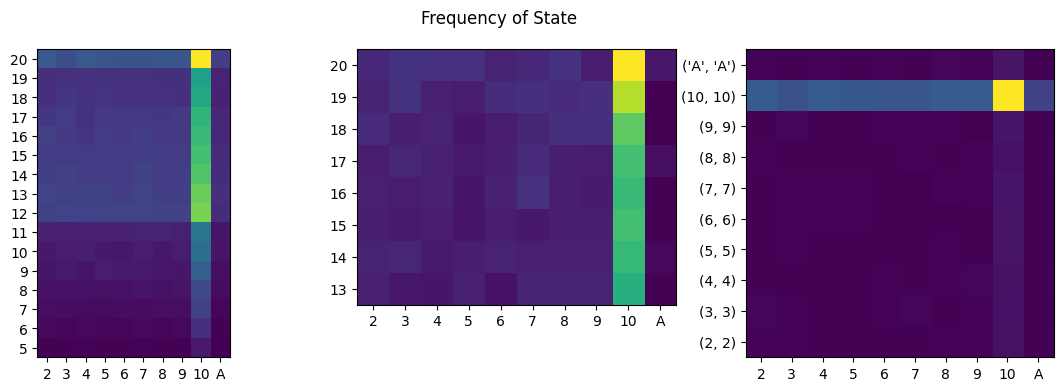

In [17]:
fig = plt.figure(figsize=(14,4))
fig.suptitle("Frequency of State")
ax = fig.add_subplot(131)
ax.imshow(hard)
ax.set_anchor("N")
ax.set_yticks(range(16), range(20, 4, -1))
ax.set_xticks(range(10), list(range(2, 11)) + ["A"])

ax = fig.add_subplot(132)
ax.imshow(soft)
ax.set_anchor("N")
ax.set_yticks(range(8), range(20, 12, -1))
ax.set_xticks(range(10), list(range(2, 11)) + ["A"])

ax = fig.add_subplot(133)
ax.imshow(split)
ax.set_anchor("N")
ax.set_yticks(range(10))
ax.set_yticklabels([("A", "A")] + [(i,i) for i in range(10,1,-1)])
ax.set_xticks(range(10), list(range(2, 11)) + ["A"])

plt.show()

## I'll start with basic house play

In [18]:
def get_val(c):
    if isinstance(c, int):
        return c
    if c == "A": return 1
    return 10

def get_tot(cards):
    total = sum(map(get_val, cards))
    ace = False
    if total <= 11:
        if cards.count("A") > 0:
            total += 10
            ace = True
    return total, ace

In [22]:
def get_odds(cards):
    # Imagine we had an infinite deck, what would be the odds of each outcome
    # if we start with a certain dealer card?
    totals = {k:0 for k in range(17,22)}
    totals["bust"] = 0

    def recurse(cards=[], n_drawn=0):

        total, _ = get_tot(cards)

        if total >= 17:
            odds = (1/13)**(n_drawn)
            if total > 21:
                totals["bust"] += odds
            else:
                totals[total] += odds
            return

        for c in [2,3,4,5,6,7,8,9,10,"J","Q","K","A"]:
            recurse(cards + [c], n_drawn + 1)
    recurse(cards)
    return totals

odds = {}

for c in [2,3,4,5,6,7,8,9,10,"J","Q","K","A"]:
    t = get_odds([c])
    odds[c] = t

In [20]:
key_assess = "bust"
# key_assess = 17
for k,v in odds.items():
    p = 100 * v[key_assess]
    print(f"Odds of {key_assess} when Dealer shows {k}: %{p:.2f}")

Odds of bust when Dealer shows 2: %35.36
Odds of bust when Dealer shows 3: %37.39
Odds of bust when Dealer shows 4: %39.45
Odds of bust when Dealer shows 5: %41.64
Odds of bust when Dealer shows 6: %42.32
Odds of bust when Dealer shows 7: %26.23
Odds of bust when Dealer shows 8: %24.47
Odds of bust when Dealer shows 9: %22.84
Odds of bust when Dealer shows 10: %21.21
Odds of bust when Dealer shows J: %21.21
Odds of bust when Dealer shows Q: %21.21
Odds of bust when Dealer shows K: %21.21
Odds of bust when Dealer shows A: %11.53


## Can I dynamically create a dictionary that tells me:

$$
P(W | P=p, D=d) = \sum_{action}P(W | P=p, D=d, action)
$$

In [42]:
cards = []
all_cards = [2,3,4,5,6,7,8,9,10,"J","Q","K","A"]
for i,c1 in enumerate(all_cards):
    for c2 in all_cards[i:]:
        cards.append([c1,c2])

In [44]:
from functools import cmp_to_key

def custom_sort(a,b):
    tot1 = get_tot(a)
    tot2 = get_tot(b)
    if tot1 > tot2:
        return -1
    if tot1 < tot2:
        return 1
    return 0

cards_sorted = sorted(cards, key=cmp_to_key(custom_sort))

In [57]:
memory = {}
def memoize_factorial(f):
    def inner(num):
        if num not in memory:
            memory[num] = f(num)
            print(f'{num} saved in memory')
        else:
            print(f'returning {num} from saved memory')
        return memory[num]
    return inner
     
@memoize_factorial
def facto(num):
    if num == 1:
        return 1
    else:
        return num * facto(num-1)
 
print(facto(5))
print(facto(8))

1 saved in memory
2 saved in memory
3 saved in memory
4 saved in memory
5 saved in memory
120
returning 5 from saved memory
6 saved in memory
7 saved in memory
8 saved in memory
40320


In [75]:
memory = {}
def memoize_fibonacci(f):
    def inner(num):
        if num not in memory:
            memory[num] = f(num)
            print(f'{num} saved in memory')
        else:
            print(f'returning {num} from saved memory')
        return memory[num]
    return inner
     
@memoize_fibonacci
def fibonacci(num):
    if num <= 1:
        return num
    else:
        return fibonacci(num-1) + fibonacci(num-2)
 
print(fibonacci(5))
print(fibonacci(8))

1 saved in memory
0 saved in memory
2 saved in memory
returning 1 from saved memory
3 saved in memory
returning 2 from saved memory
4 saved in memory
returning 3 from saved memory
5 saved in memory
5
returning 5 from saved memory
returning 4 from saved memory
6 saved in memory
returning 5 from saved memory
7 saved in memory
returning 6 from saved memory
8 saved in memory
21
